In [1]:
# Import Libraries
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
%matplotlib inline

In [2]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [ ]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [3]:
# Examine head/columns of data
data.head(1)

,id,name,summary,space,description,experiences_offered,house_rules,host_id,host_since,host_location,...,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,3176,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,"It’s a non smoking flat, which likes to be tre...",3718,2008-10-19,"Coledale, New South Wales, Australia",...,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1,1.12


In [4]:
data.shape

(25197, 54)

In [ ]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

In [5]:
# List correlation values
data.corr()

,id,host_id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,number_of_reviews,number_of_reviews_ltm,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
id,1.000000,0.532084,0.030264,0.015998,-0.011600,0.000710,0.002976,-0.061381,-0.018171,0.034594,...,-0.282780,-0.030802,-0.002629,-0.002537,-0.000632,0.000803,0.058463,0.014291,0.074544,0.191264
host_id,0.532084,1.000000,0.046072,0.020198,-0.040746,0.010186,0.001749,-0.050964,0.016888,0.046379,...,-0.122332,0.043162,-0.047685,-0.044193,-0.024828,-0.048454,-0.014734,-0.033432,0.009834,0.204739
host_listings_count,0.030264,0.046072,1.000000,-0.016127,-0.014927,0.086019,0.019763,0.039655,0.098989,0.019112,...,0.000066,0.005117,-0.026760,0.005974,-0.022380,-0.034825,-0.041294,-0.046891,0.181913,0.055119
latitude,0.015998,0.020198,-0.016127,1.000000,-0.111603,0.018675,-0.007267,0.000262,0.000299,0.006163,...,0.036405,0.041583,-0.000071,-0.000444,-0.018856,-0.010163,-0.006455,-0.010591,0.040044,0.055093
longitude,-0.011600,-0.040746,-0.014927,-0.111603,1.000000,-0.005172,-0.021833,-0.011966,-0.012970,-0.035711,...,-0.022473,-0.024429,-0.006343,-0.011677,-0.011363,0.001646,-0.016430,0.010949,-0.045984,-0.028605
accommodates,0.000710,0.010186,0.086019,0.018675,-0.005172,1.000000,0.274985,0.638654,0.767407,0.124913,...,0.139402,0.146490,-0.040898,-0.004249,-0.017762,-0.022317,-0.036145,-0.090519,0.216120,0.138769
bathrooms,0.002976,0.001749,0.019763,-0.007267,-0.021833,0.274985,1.000000,0.331644,0.276640,0.061340,...,0.015257,0.015803,0.006712,0.010148,0.008075,0.008749,-0.003967,-0.000675,0.059609,0.016025
bedrooms,-0.061381,-0.050964,0.039655,0.000262,-0.011966,0.638654,0.331644,1.000000,0.610308,0.104327,...,0.041499,0.024512,0.012136,0.036119,0.024360,0.027222,-0.004312,-0.002135,0.059686,0.006387
beds,-0.018171,0.016888,0.098989,0.000299,-0.012970,0.767407,0.276640,0.610308,1.000000,0.093862,...,0.095467,0.102303,-0.056009,-0.019539,-0.018219,-0.032513,-0.056422,-0.083856,0.178028,0.097353
price,0.034594,0.046379,0.019112,0.006163,-0.035711,0.124913,0.061340,0.104327,0.093862,1.000000,...,0.001850,0.010234,-0.033489,0.011337,0.011436,-0.002413,0.023536,-0.044559,0.078785,0.036190


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


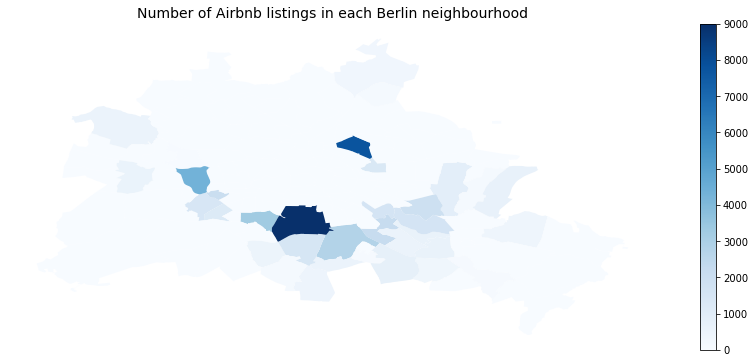

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


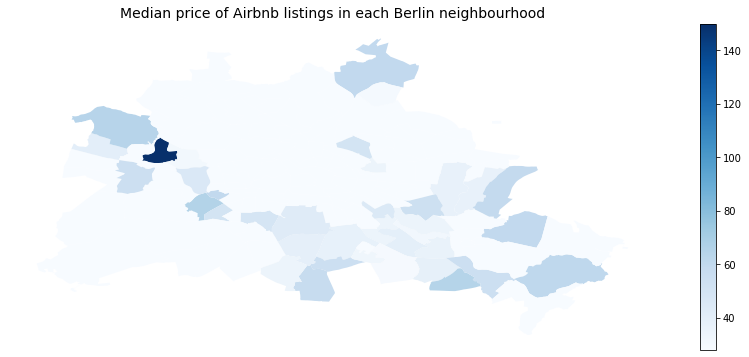

In [7]:
# Display contents of neighbourhoods.geojson visually (not working properly, ON HOLD)

# Load up the file
data_2019_12_11_neighb_geojson = gpd.read_file('data/2019-12-11/neighbourhoods.geojson')

# Dropping the redundant column
data_2019_12_11_neighb_geojson.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(data.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = data.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = data_2019_12_11_neighb_geojson.set_index('neighbourhood').join(neighbourhood_df)

# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()